In [1061]:
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
%config InlineBackend.figure_format = 'svg'

In [1062]:
df = pd.read_csv('./daily-min-temperatures.csv')
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [1063]:
df['Date'] = pd.to_datetime(df['Date'])
df.index = df['Date']
df.drop(['Date'], axis=1, inplace= True)

In [1064]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3650 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Temp    3650 non-null   float64
dtypes: float64(1)
memory usage: 57.0 KB


In [1065]:
def draw_ts(timeseries):
    f = plt.figure(facecolor='white')
    timeseries.plot(color='blue')
    plt.show()

def draw_trend(timeseries, size):
    f = plt.figure(facecolor='white')
    # 对size个数据进行移动平均
    rol_mean = timeseries.rolling(window=size).mean()
    # 对size个数据移动平均的方差
    rol_std = timeseries.rolling(window=size).std()

    timeseries.plot(color='blue', label='Original')
    rol_mean.plot(color='red', label='Rolling Mean')
    rol_std.plot(color='black', label='Rolling standard deviation')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

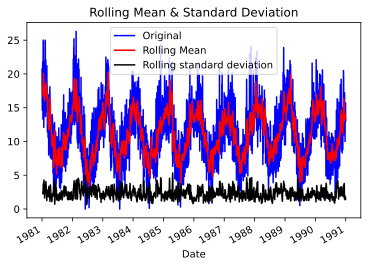

In [1066]:
ts = df['Temp']
draw_trend(ts,10)

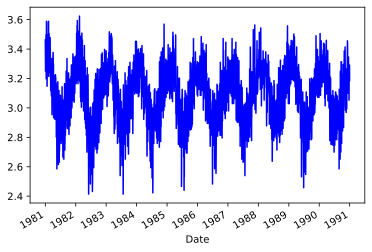

In [1067]:
data_min = min(ts) - np.average(ts)
ts = ts - data_min
ts_log = np.log(ts)
# ts_log = ts
draw_ts(ts_log)

In [1068]:
diff_1 = ts_log.diff(365)
diff_1.dropna(inplace=True)

In [1069]:
diff_1_1 = diff_1.diff(1)
# True表示修改数据
diff_1_1.dropna(inplace=True)

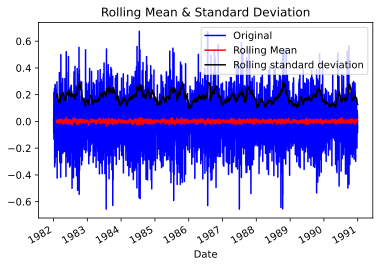

In [1070]:
draw_trend(diff_1_1,30)

In [1071]:
model1 = sm.tsa.statespace.SARIMAX(ts_log, order=(2, 2, 2),seasonal_order=(1,1,0,7))

d:\11516\usual\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\11516\usual\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [1072]:
result_arima = model1.fit(disp=True)

d:\11516\usual\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


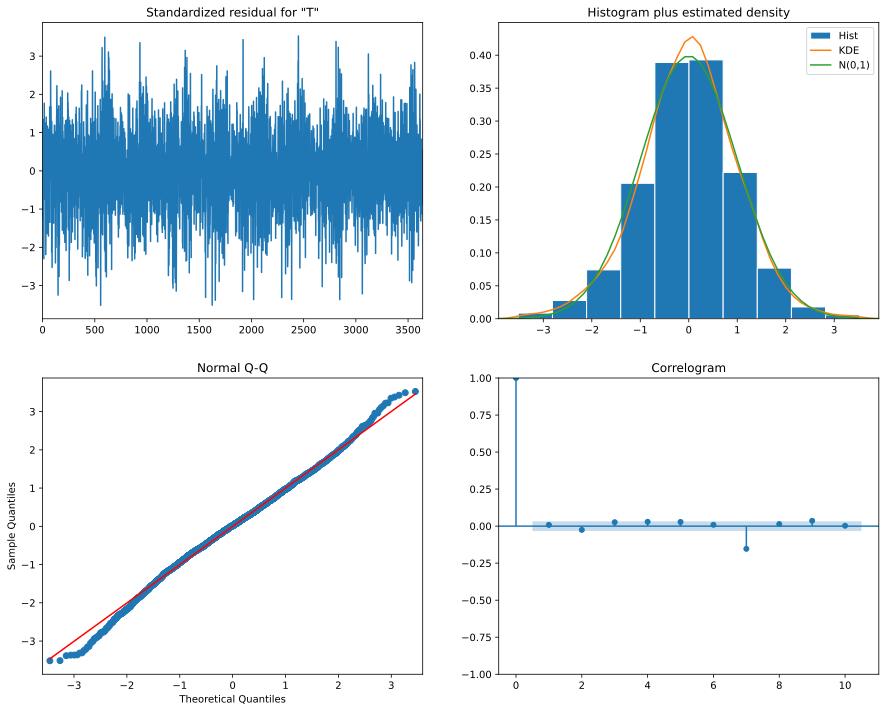

In [1073]:
result_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [1074]:
predict_ts = result_arima.predict()
predict_ts_af = result_arima.predict(start=pd.to_datetime('1989-01-01'), dynamic=True, full_results=True)
predict_ts_forecast = result_arima.forecast(steps=365)

d:\11516\usual\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [1075]:
from datetime import timedelta
predict_ts_forecast.index = pd.date_range(start='1991-01-01', periods=len(predict_ts_forecast))

log_recover = np.exp(predict_ts)
log_recover.dropna(inplace=True)

log_recover_af = np.exp(predict_ts_af)
log_recover_af.dropna(inplace=True)

log_recover_forecast = np.exp(predict_ts_forecast)
log_recover_forecast.dropna(inplace=True)




In [1076]:
testsize = 180
log_recover = log_recover[-testsize:]
predict_ts = predict_ts[-testsize:]
log_recover_af = log_recover[-testsize:]



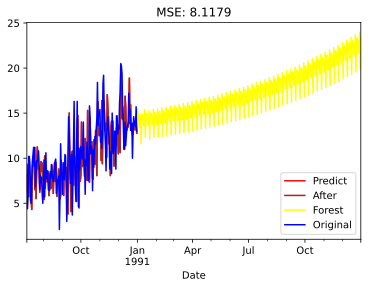

In [1077]:
ts = ts[log_recover.index]

ts = ts + data_min
log_recover = log_recover + data_min
log_recover_af = log_recover_af + data_min
log_recover_forecast = log_recover_forecast + data_min


log_recover.plot(color='red', label = 'Predict')
log_recover_af.plot(color='brown', label = 'After')
log_recover_forecast.plot(color='yellow', label = 'Forest')


ts.plot(color='blue', label='Original')
plt.legend(loc='best')
plt.title('MSE: %.4f'% mean_squared_error(log_recover,ts))
plt.show()